# LightGBM, Load Modules, Install LightGBM

## Load Modules, Import Dataset

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


from scipy.stats import uniform
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, RobustScaler, KBinsDiscretizer, StandardScaler
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification

df = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/dataset.csv')


### Make additional categorical feature out of days_since_last_contact

In [2]:
df['days_since_last_contact'] = np.where(df['days_since_last_contact'].between(1,5), 1, df['days_since_last_contact'])
df['days_since_last_contact'] = df['days_since_last_contact'].mask(df['days_since_last_contact'] >= 6, 2)
df['days_since_last_contact'] = df['days_since_last_contact'].mask(df['days_since_last_contact'] == -1, 999)

df['days_since_last_contact_cat'] = np.where(df['days_since_last_contact'].between(1,5), 1, df['days_since_last_contact'])
df['days_since_last_contact_cat'] = df['days_since_last_contact'].mask(df['days_since_last_contact'] >= 6, 2)
df['days_since_last_contact_cat'] = df['days_since_last_contact'].mask(df['days_since_last_contact'] == -1, 999)
df['days_since_last_contact_cat'] = np.where(df['days_since_last_contact_cat'].between(1,5), 1, df['days_since_last_contact'])
df['days_since_last_contact_cat'] = df['days_since_last_contact_cat'].mask(df['days_since_last_contact'] >= 6, 2)
df['days_since_last_contact_cat'] = df['days_since_last_contact_cat'].mask(df['days_since_last_contact'] == -1, 999)

In [3]:
df["days_since_last_contact_cat"] = df["days_since_last_contact_cat"].astype('object')

In [4]:
#df["n_contacts_before"] = df["n_contacts_before"].astype('object')

In [5]:
df.head()

,identifier,date,age,marital_status,education,job,credit_default,housing_loan,personal_loan,communication_type,n_contacts_campaign,days_since_last_contact,n_contacts_before,previous_conversion,duration,success,days_since_last_contact_cat
0,34203,2009-05-06,36,divorced,High School,Service provider,No,No,Yes,Landline network,5,999,0,Inexistent,992,No,2
1,1250,2008-05-08,32,single,University,Student,No,Yes,No,Landline network,1,999,0,Inexistent,147,No,2
2,38130,2009-09-04,68,single,University,Pensioner,No,Yes,No,Celluar phone network,1,999,0,Inexistent,139,No,2
3,19300,2008-08-06,39,single,University,Administrator,No,No,No,Celluar phone network,1,999,0,Inexistent,127,No,2
4,34497,2009-05-07,30,married,Middle School,Administrator,No,No,No,Celluar phone network,1,999,1,Failed,586,No,2


## Featuretool for finding features

In [6]:
import featuretools as ft

In [7]:
es = ft.EntitySet(id = 'df')

es = es.entity_from_dataframe(entity_id='df', 
                              dataframe = df, 
                              index = 'identifier', 
                              time_index = 'date', 
                              variable_types = {"identifier": ft.variable_types.Index, "age":ft.variable_types.Ordinal ,"marital_status": ft.variable_types.Categorical, 
                                                "education": ft.variable_types.Categorical, "job": ft.variable_types.Categorical, "credit_default": ft.variable_types.Boolean, 
                                                "housing_loan": ft.variable_types.Boolean, "personal_loan": ft.variable_types.Boolean, "communication_type": ft.variable_types.Categorical, 
                                                "n_contacts_campaign": ft.variable_types.Ordinal, "days_since_last_contact": ft.variable_types.variable.Numeric, 
                                                "n_contacts_before": ft.variable_types.variable.Ordinal, "previous_conversion": ft.variable_types.variable.Categorical, 
                                                "duration": ft.variable_types.variable.Numeric, "success": ft.variable_types.variable.Boolean, "days_since_last_contact_cat": ft.variable_types.variable.Categorical})

es['df']

df_new, df_new_names = ft.dfs(entityset=es, target_entity='df',
                              trans_primitives = ['day', 'weekday', 'week', 'percentile'],
                              max_depth = 2)

In [8]:
'''pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
ft.primitives.list_primitives()'''

"pd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\nft.primitives.list_primitives()"

In [9]:
df_new = df_new.loc[:,df_new.apply(pd.Series.nunique) != 1]

In [10]:
df = df_new

In [11]:
df_new.head()

,age,marital_status,education,job,credit_default,housing_loan,personal_loan,communication_type,n_contacts_campaign,days_since_last_contact,n_contacts_before,previous_conversion,duration,success,days_since_last_contact_cat,DAY(date),WEEKDAY(date),WEEK(date),PERCENTILE(duration),PERCENTILE(days_since_last_contact)
identifier,,,,,,,,,,,,,,,,,,,,
0,56,married,Elementary School,Housemaid,No,No,No,Landline network,1,999,0,Inexistent,261,No,2,5,0,19,0.670803,0.518236
1,57,married,High School,Service provider,Unknown,No,No,Landline network,1,999,0,Inexistent,149,No,2,5,0,19,0.407551,0.518236
2,37,married,High School,Service provider,No,Yes,No,Landline network,1,999,0,Inexistent,226,No,2,5,0,19,0.607232,0.518236
3,40,married,Middle School,Administrator,No,No,No,Landline network,1,999,0,Inexistent,151,No,2,5,0,19,0.413567,0.518236
4,56,married,High School,Service provider,No,No,Yes,Landline network,1,999,0,Inexistent,307,No,2,5,0,19,0.734590,0.518236


In [12]:
dtypes = pd.DataFrame(df_new.dtypes.rename('type')).reset_index().astype('str')
# Exclude duration since it is a leaky variable
dtypes = dtypes.query('index != "duration"')
numeric = dtypes[(dtypes.type.isin(['int64', 'float64'])) & (dtypes['index'] != 'duration')]['index'].values
categorical = dtypes[~(dtypes['index'].isin(numeric)) & (dtypes['index'] != 'success')]['index'].values

## Regular Oversampling of minority class
Here the code samples our miniority class of "Yes" cases up three times to even out some of the unbalanced dataset to reduce the overall failure-proof quality of the learning.

In [13]:
df['success'].value_counts()

No     32893
Yes     4176
Name: success, dtype: int64

In [14]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_new[df_new.success=='No']
df_minority = df_new[df_new.success=='Yes']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=15000,    # to match majority class
                                 random_state=1909) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.success.value_counts()

No     32893
Yes    15000
Name: success, dtype: int64

In [15]:
df_new = df_upsampled
df = df_upsampled

## Categorical analysis

In [16]:
# Missing data?
df_new[categorical].isnull().sum()

marital_status                 0
education                      0
job                            0
credit_default                 0
housing_loan                   0
personal_loan                  0
communication_type             0
previous_conversion            0
days_since_last_contact_cat    0
dtype: int64

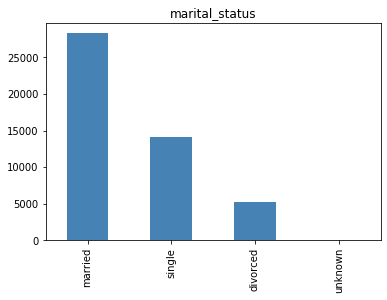

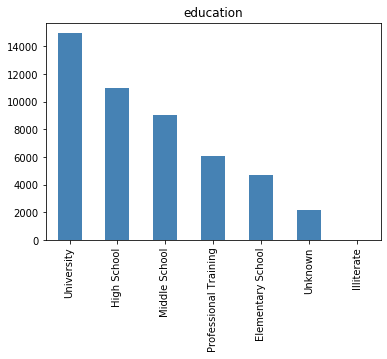

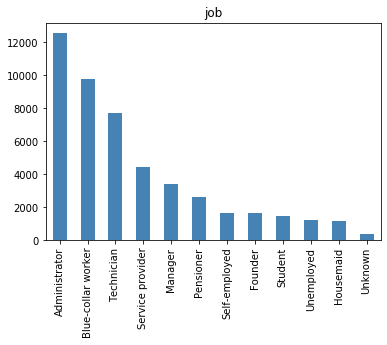

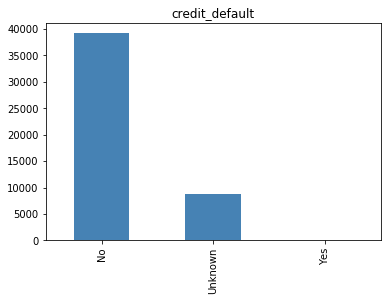

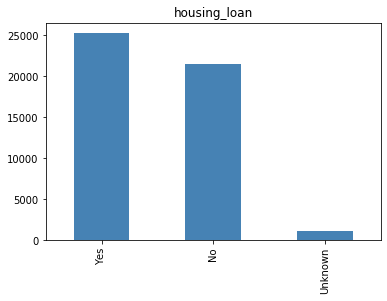

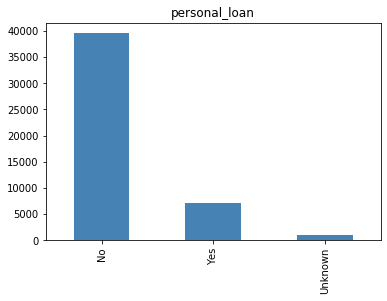

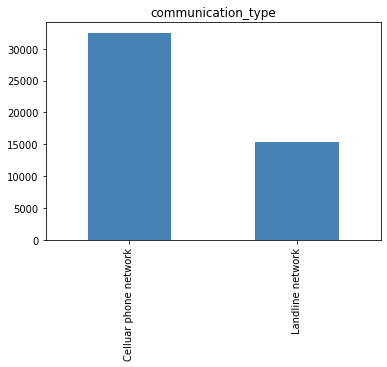

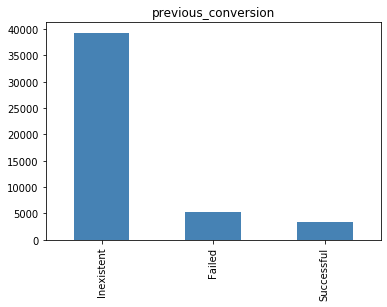

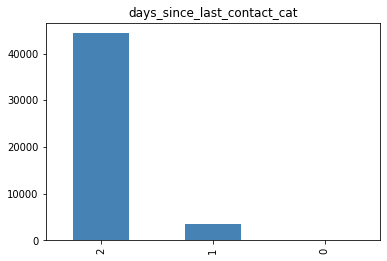

In [17]:
# Values distributed across categorical attributes
for attr in categorical:
  plt.figure()
  df_new[attr].value_counts().plot(kind='bar', color='steelblue');
  plt.title(attr);

- No missing data about the marital status, therefore good understanding of it
- No (or very few) customers are illiterate
- No or very few customers who have defaulted on a loan, hereby we can state the fact that the bank probably does not want to extend an offer to a customer with bad credit. But: We have a lot of unknown values. 
- Proportions of customers with / without housing loan are similar
- Few customers have a personal loan
- Double as many celluar as landline phone calls
- Previous conversions mostly failed or (for the most part) are inexistent. Very few were successful
- During the current campaign most of the calls were not successful

Support (marital_status)

married     28296
single      14188
divorced     5304
unknown       105
Name: marital_status, dtype: int64 

Support (education)

University               14973
High School              10978
Middle School             9037
Professional Training     6076
Elementary School         4681
Unknown                   2131
Illiterate                  17
Name: education, dtype: int64 

Support (job)

Administrator         12551
Blue-collar worker     9785
Technician             7686
Service provider       4419
Manager                3381
Pensioner              2582
Self-employed          1662
Founder                1624
Student                1458
Unemployed             1215
Housemaid              1150
Unknown                 380
Name: job, dtype: int64 

Support (credit_default)

No         39187
Unknown     8703
Yes            3
Name: credit_default, dtype: int64 

Support (housing_loan)

Yes        25242
No         21522
Unknown     1129
Name: housing_loan, dtype: in

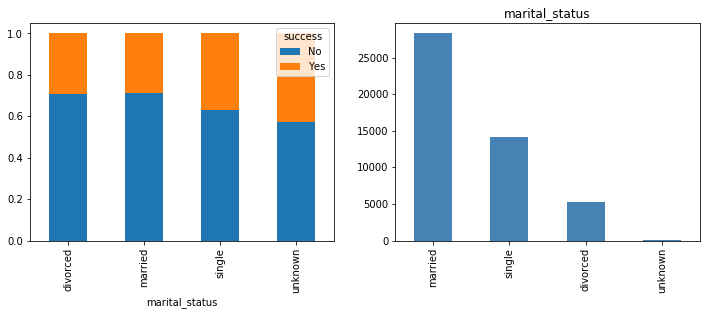

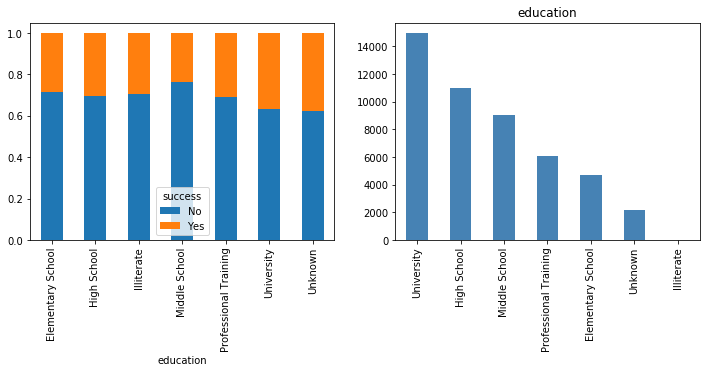

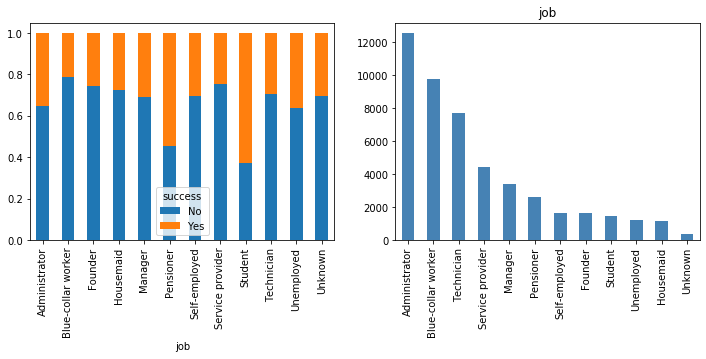

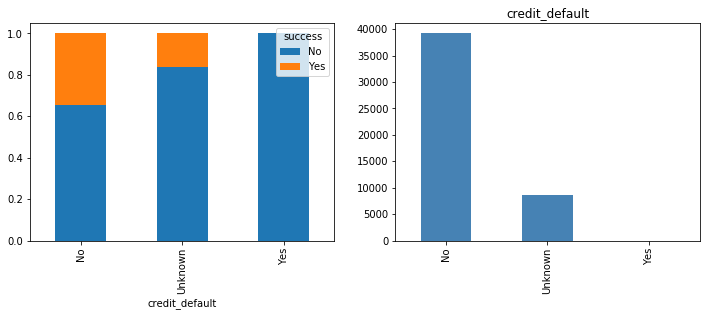

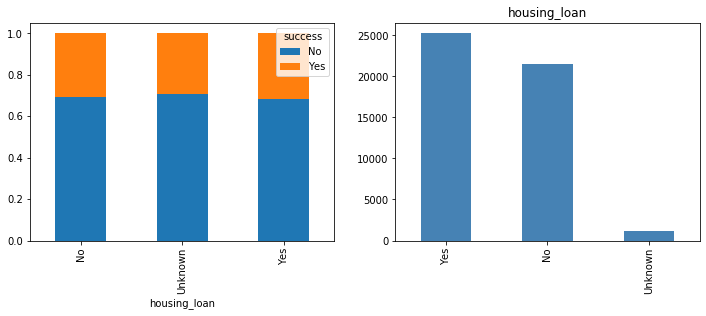

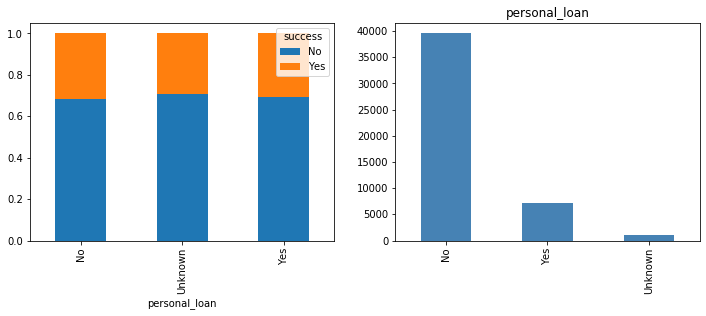

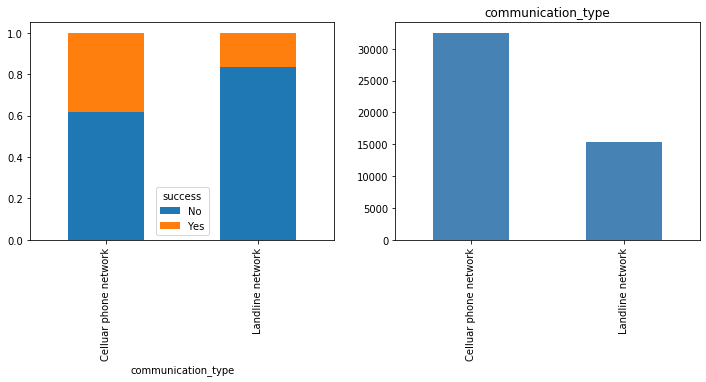

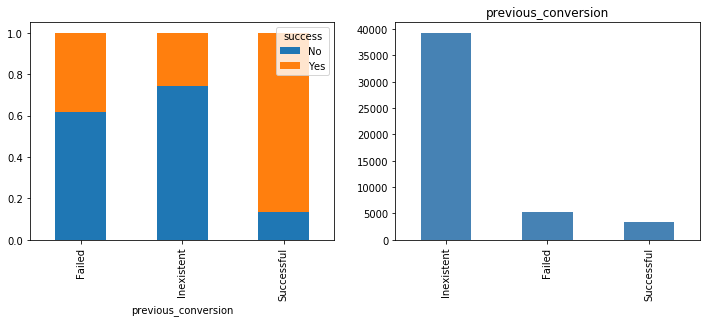

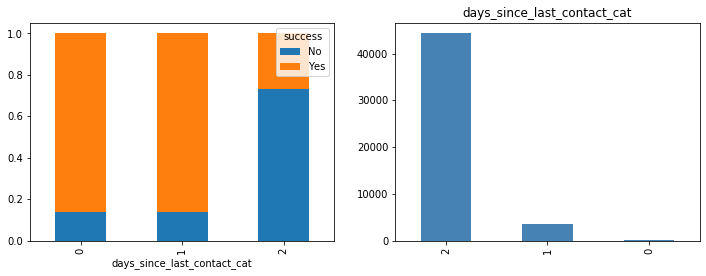

In [18]:
for attr in categorical:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  outcome_counts = df_new.groupby([attr, 'success']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='success', values='count', index=attr)
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
  # Plot the counts
  df_new[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
  print('Support (%s)\n' % attr)
  print(df_new[attr].value_counts(), '\n')
  plt.title(attr);

## Numerical analysis

In [19]:
# Missing data?
df_new[numeric].isnull().sum()

age                                    0
n_contacts_campaign                    0
days_since_last_contact                0
n_contacts_before                      0
DAY(date)                              0
WEEKDAY(date)                          0
WEEK(date)                             0
PERCENTILE(duration)                   0
PERCENTILE(days_since_last_contact)    0
dtype: int64

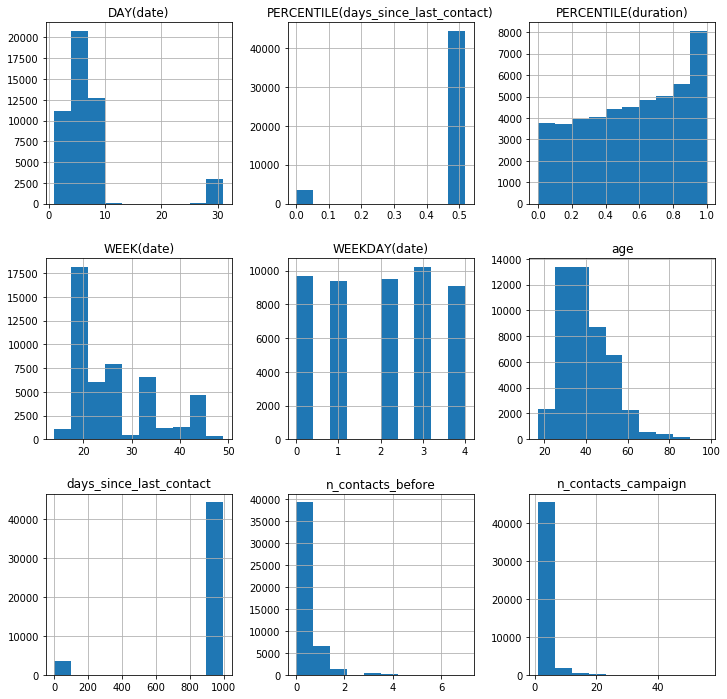

In [20]:
df_new[numeric].hist(figsize=(12,12));

- The customer age is mostly between 20 and 60, only a few over 60 (variable age)
- The customers were contacted at most a few days ago (variable days_since_last_contact)
- The customers were mostly not contacted about the previous campaign, but also not often contacted about the current campaign

In [21]:
df_new[numeric].describe()

,age,n_contacts_campaign,days_since_last_contact,n_contacts_before,DAY(date),WEEKDAY(date),WEEK(date),PERCENTILE(duration),PERCENTILE(days_since_last_contact)
count,47893.000000,47893.000000,47893.000000,47893.000000,47893.000000,47893.000000,47893.000000,47893.000000,47893.000000
mean,40.253377,2.454304,924.480801,0.243480,6.653081,1.993214,26.343850,0.563357,0.480885
std,11.323350,2.580700,262.257541,0.608375,6.445910,1.406135,8.670718,0.295836,0.131476
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,14.000000,0.000054,0.000202
25%,32.000000,1.000000,999.000000,0.000000,4.000000,1.000000,19.000000,0.314346,0.518236
50%,38.000000,2.000000,999.000000,0.000000,5.000000,2.000000,23.000000,0.590844,0.518236
75%,48.000000,3.000000,999.000000,0.000000,7.000000,3.000000,32.000000,0.832650,0.518236
max,98.000000,56.000000,999.000000,7.000000,31.000000,4.000000,49.000000,1.000000,0.518236


- Average age of sighted customers: 38
- Contacts during the current campaign on average: 2 times
- Days since last contact: -1, because mostly the customer have not been contacted before. We should not consider the "-1" values and see what happens
- Contacts before current campaign on average: zero times

Hereby we can conclude that days_since_last_contact has an awful lot of customers which value is missing (-1). That can be problematic, is problematic, due to the fact that it manipulates the data. Because few customers have an instance of days_since_last_contact associated we should consider to drop it and see what happens!

## X,y definition

In [22]:
#df_new.drop('duration', axis=1)
X, y = df.drop('success', axis=1), df.success

## Splitting into Train and Test data


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1909, stratify=y, shuffle=True, test_size=.2)

In [24]:
print(X.shape)
print(y.shape)
print(X_test.shape)

(47893, 19)
(47893,)
(9579, 19)


In [25]:
X.dtypes.groupby(X.dtypes).size()

int64      8
float64    2
object     9
dtype: int64

## Feature Engineering

In [26]:
def ft_pcontacted_last_campaign(X):
    pcontacted = ~(X == 999) & (X == -1)
    return pcontacted.values.reshape(-1,1)

def ft_pcampaign(X):
    pcampaign = ~(X == 'Inexistent')
    return pcampaign.values.reshape(-1,1)

def ft_previous(X):
    previous = X.astype(str)
    return previous.values.reshape(-1,1)

def ft_campaign_gte10(X):
    campaign_gte10 = X >= 10
    return campaign_gte10.values.reshape(-1,1)

def ft_campaign_to_previous(X):
    ratio = lambda x: 0 if (X.n_contacts_before).all() == 0 else (X.n_contacts_campaign).all() / (X.n_contacts_before).all()
    campaign_to_previous = X[['n_contacts_campaign', 'n_contacts_before']].apply(ratio, axis=1)
    return campaign_to_previous.values.reshape(-1,1)

add_pcontacted_last_campaign = FunctionTransformer(ft_pcontacted_last_campaign, validate=False)
add_pcampaign = FunctionTransformer(ft_pcampaign, validate=False)
add_previous = FunctionTransformer(ft_previous, validate=False)
add_campaign_gte10 = FunctionTransformer(ft_campaign_gte10, validate=False)
add_campaign_to_previous = FunctionTransformer(ft_campaign_to_previous, validate=False)

cat_features = [
        ('ft_pcontacted_last_campaign', add_pcontacted_last_campaign, 'days_since_last_contact'),
        ('ft_pcampaign', add_pcampaign, 'previous_conversion'),
        ('ft_previous', add_previous, 'n_contacts_before'),
        ('ft_campaign_gte10', add_campaign_gte10, 'n_contacts_campaign')]

cat_ct = ColumnTransformer(cat_features)

cat_pipeline = Pipeline([
  ('cat_ct', cat_ct),
  ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
cat_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('cat_ct',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ft_pcontacted_last_campaign',
                                                  FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      func=<function ft_pcontacted_last_campaign at 0x7f46435d1820>,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      validate...
                             

In [27]:
binning_pipeline = Pipeline([
  ('log', FunctionTransformer(np.log, validate=True)),
  ('kbins', KBinsDiscretizer())
])

age_campaign_ct = ColumnTransformer([
  ('age_pipeline', clone(binning_pipeline), ['age']),
  ('campaign_pipeline', clone(binning_pipeline), ['n_contacts_campaign'])
])

new_num_features = [
    ('ft_campaign_to_previous', FunctionTransformer(ft_campaign_to_previous, validate=False))
]

num_union = FeatureUnion(new_num_features)

num_pipeline = Pipeline([
    ('num_union', num_union),
    ('scaler', RobustScaler())
])
num_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('num_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('ft_campaign_to_previous',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function ft_campaign_to_previous at 0x7f46435d1af0>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     validate=False))],
                              transformer_weights=None, verbose=False)),
                ('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
      

In [28]:
cat_ct.fit_transform(X_train).shape

(38314, 4)

In [29]:
feature_names = [
  # Don't incclude the last entry in the `named_transformers_` list since
  # it's the `remainder` parameter for the ColumnTransformer
  ['%s_%s' % (name, value) for value in values] for 
    name, values in list(zip(list(cat_ct.named_transformers_.keys())[1:], cat_pipeline.named_steps['ohe'].categories_))]

cat_feature_names = [name for names in feature_names for name in names]
cat_feature_names

['ft_pcampaign_False',
 'ft_previous_False',
 'ft_previous_True',
 'ft_campaign_gte10_0',
 'ft_campaign_gte10_1',
 'ft_campaign_gte10_2',
 'ft_campaign_gte10_3',
 'ft_campaign_gte10_4',
 'ft_campaign_gte10_5',
 'ft_campaign_gte10_6',
 'remainder_False',
 'remainder_True']

## Pipeline Creation, Classifier LightGBM Implementation

In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [31]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [33]:
ft_union = FeatureUnion([
    ('cat_pipeline', cat_pipeline),
    ('age_campaign_ct', age_campaign_ct),
    ('num_union', num_union),
    ('preprocessor', preprocessor)])

In [34]:
ft_union.fit(X)
features = ft_union.transform(X)
features.shape

/home/maarch/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:195: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


(47893, 72)

In [35]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# We have chosen the Light GBM Classifier. It's a relative new algorithm that is not only fast but has also a very good acuracy
lgbm = LGBMClassifier(objective='binary', random_state=1909)
smo = SMOTE(random_state=1909)
scorer = make_scorer(f1_score, pos_label='Yes')

# RandomizedSearchCV parameters
params = {
    'classifier__learning_rate': [0.05, 0.1, 0.5],    
    'classifier__boosting' : ['gbdt'],
    'classifier__max_depth' : [-1],
    'classifier__feature_fraction' : [0.7,1.0],
    'classifier__min_gain_to_split' : [0.0,0.01,0.05],
    'classifier__min_data_in_leaf':[60, 65, 70],
    'classifier__metric':['auc'],
    'classifier__max_bin':[240, 245, 250],
    'classifier__num_iterations':[245, 250, 255],
    'classifier__num_leaves':[500, 505, 510],
    'classifier__scale_pos_weight': [1, 100, 1000],
    'sampling__sampling_strategy': [0.4, 0.8,'minority']
    }

rf = Pipeline(steps=[('ft_union', ft_union),
                     ('sampling', smo),             ### SMOTE ###                     
                     ('classifier', lgbm)])

In [36]:
# GridSearch
#grid = GridSearchCV(rf, params, scoring=scorer, verbose=1, cv=5, n_jobs=-1, return_train_score=True)
#grid.fit(X_train, y_train)

# RandomizedSearch
grid = RandomizedSearchCV(rf, params, scoring=scorer, verbose=1, cv=10, n_jobs=-1, n_iter=15, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
/home/maarch/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.1min finished
/home/maarch/venv/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:195: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/home/maarch/venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ft_union',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('cat_pipeline',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('cat_ct',
                                                                                               ColumnTransformer(n_jobs=None,
                                                                                                                 remainder='drop',
                                                                                                                 sparse_threshold=0.3,
                                                                                     

## Evaluation

In [37]:
training_score = grid.cv_results_['mean_train_score'][grid.best_index_] * 100
test_score = grid.cv_results_['mean_test_score'][grid.best_index_] * 100

In [38]:
#grid.cv_results_['mean_fit_time']
#grid.cv_results_['mean_score_time']
grid.cv_results_['mean_train_score']

array([0.79073269, 1.        ,        nan,        nan, 1.        ,
       0.98254675, 0.63327902,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.99842271])

In [39]:
f'Mean F1 Score (Training/Test): {training_score:.2f}%/{test_score:.2f}%'

'Mean F1 Score (Training/Test): 100.00%/92.31%'

In [40]:
# importance of each attribute
#print(grid.best_estimator_.named_steps["classifier"].get_fscore())
#grid.best_estimator_.named_steps["classifier"].feature_importances_
#fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

print("\nBest Parameters = " + str(grid.best_estimator_.named_steps['classifier'].get_params))


Best Parameters = <bound method LGBMModel.get_params of LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.1, max_bin=250,
               max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=60,
               min_gain_to_split=0.0, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=245, num_leaves=500,
               objective='binary', random_state=1909, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)>


In [41]:
predictors=list(X_train)

print('Accuracy of the GBM on test set: {:.3f}'.format(grid.score(X_test, y_test)))
pred=grid.predict(X_test)
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.923
              precision    recall  f1-score   support

          No       0.99      0.94      0.96      6579
         Yes       0.88      0.97      0.92      3000

    accuracy                           0.95      9579
   macro avg       0.93      0.96      0.94      9579
weighted avg       0.95      0.95      0.95      9579



# Prediction

In [42]:
prediction_dataset = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/prediction-dataset.csv')

In [43]:
prediction_dataset['days_since_last_contact'] = np.where(prediction_dataset['days_since_last_contact'].between(1,5), 1, prediction_dataset['days_since_last_contact'])
prediction_dataset['days_since_last_contact'] = prediction_dataset['days_since_last_contact'].mask(prediction_dataset['days_since_last_contact'] >= 6, 2)
prediction_dataset['days_since_last_contact'] = prediction_dataset['days_since_last_contact'].mask(prediction_dataset['days_since_last_contact'] == -1, 999)

prediction_dataset['days_since_last_contact_cat'] = np.where(prediction_dataset['days_since_last_contact'].between(1,5), 1, prediction_dataset['days_since_last_contact'])
prediction_dataset['days_since_last_contact_cat'] = prediction_dataset['days_since_last_contact'].mask(prediction_dataset['days_since_last_contact'] >= 6, 2)
prediction_dataset['days_since_last_contact_cat'] = prediction_dataset['days_since_last_contact'].mask(prediction_dataset['days_since_last_contact'] == -1, 999)
prediction_dataset['days_since_last_contact_cat'] = np.where(prediction_dataset['days_since_last_contact_cat'].between(1,5), 1, prediction_dataset['days_since_last_contact'])
prediction_dataset['days_since_last_contact_cat'] = prediction_dataset['days_since_last_contact_cat'].mask(prediction_dataset['days_since_last_contact'] >= 6, 2)
prediction_dataset['days_since_last_contact_cat'] = prediction_dataset['days_since_last_contact_cat'].mask(prediction_dataset['days_since_last_contact'] == -1, 999)

In [44]:
prediction_dataset["days_since_last_contact_cat"] = prediction_dataset["days_since_last_contact_cat"].astype('object')

In [45]:
es = ft.EntitySet(id = 'prediction_dataset')

es = es.entity_from_dataframe(entity_id='prediction_dataset', 
                              dataframe = prediction_dataset, 
                              index = 'identifier', 
                              time_index = 'date', 
                              variable_types = {"identifier": ft.variable_types.Index, "age":ft.variable_types.Ordinal ,"marital_status": ft.variable_types.Categorical, 
                                                "education": ft.variable_types.Categorical, "job": ft.variable_types.Categorical, "credit_default": ft.variable_types.Boolean, 
                                                "housing_loan": ft.variable_types.Boolean, "personal_loan": ft.variable_types.Boolean, "communication_type": ft.variable_types.Categorical, 
                                                "n_contacts_campaign": ft.variable_types.Ordinal, "days_since_last_contact": ft.variable_types.variable.Numeric, 
                                                "n_contacts_before": ft.variable_types.variable.Ordinal, "previous_conversion": ft.variable_types.variable.Categorical, 
                                                "duration": ft.variable_types.variable.Numeric, "days_since_last_contact_cat": ft.variable_types.variable.Categorical})

es['prediction_dataset']

prediction_dataset_new, prediction_dataset_new_names = ft.dfs(entityset=es, target_entity='prediction_dataset',
                              trans_primitives = ['day', 'weekday', 'week', 'percentile'],
                              max_depth = 2)

In [46]:
cols = list(df_new.columns.values)
print(cols)
prediction_dataset_new = prediction_dataset_new[['age', 'marital_status', 'education', 'job', 'credit_default', 'housing_loan', 'personal_loan', 'communication_type', 'n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before', 'previous_conversion', 'duration', 'days_since_last_contact_cat', 'DAY(date)', 'WEEKDAY(date)', 'WEEK(date)', 'PERCENTILE(duration)', 'PERCENTILE(days_since_last_contact)']]

['age', 'marital_status', 'education', 'job', 'credit_default', 'housing_loan', 'personal_loan', 'communication_type', 'n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before', 'previous_conversion', 'duration', 'success', 'days_since_last_contact_cat', 'DAY(date)', 'WEEKDAY(date)', 'WEEK(date)', 'PERCENTILE(duration)', 'PERCENTILE(days_since_last_contact)']


In [47]:
predictions = grid.best_estimator_.predict(prediction_dataset_new)

# Submission Dataset Preparation

In [48]:
submission = pd.DataFrame(predictions, index=prediction_dataset.index, columns=['prediction'])

In [49]:
matrikel_mheichler = '465475'
matrikel_psaustum = '470057'

In [50]:
submission.to_csv(f'./submission-{matrikel_mheichler}-{matrikel_psaustum}.csv', index_label='identifier')